In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import random_split
import random
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F
import torch.nn.init as init
import itertools


# Load data and split in the multi agent system

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16505253.90it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 534713.91it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3925449.01it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10750862.74it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

First batch of the first agent:
  Images shape: torch.Size([32, 1, 28, 28])
  Labels: tensor([3, 6, 0, 7, 4, 4, 9, 3, 8, 9, 6, 1, 4, 0, 9, 2, 3, 6, 6, 9, 3, 7, 6, 8,
        4, 9, 3, 2, 4, 8, 8, 4])


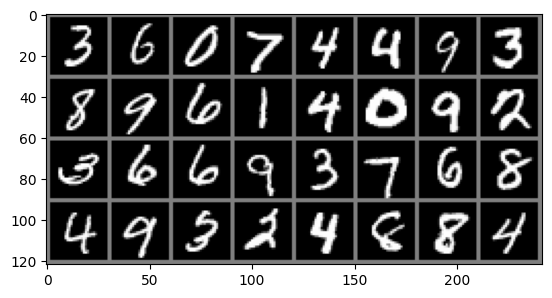

In [ ]:
def load_cifar10():
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                 download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                                download=True, transform=transform)
    return train_dataset, test_dataset

# def load_mnist(train_subset_size=15000, test_subset_size=1500):
#     transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize((0.5,), (0.5,))
#     ])

#     # Load the full datasets
#     train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
#     test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

#     # Get the subset of indices
#     train_indices = np.random.choice(len(train_dataset), train_subset_size, replace=False)
#     test_indices = np.random.choice(len(test_dataset), test_subset_size, replace=False)

#     # Create subsets
#     train_subset = Subset(train_dataset, train_indices)
#     test_subset = Subset(test_dataset, test_indices)

#     return train_subset, test_subset

def load_mnist():
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5), (0.5))])

    train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                                 download=True, transform=transform)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                                download=True, transform=transform)
    return train_dataset, test_dataset

def split_dataset_heterogeneously(dataset, num_agents, alpha=0.2):
    num_samples = len(dataset)
    indices = np.random.permutation(num_samples)
    # Generate Dirichlet distribution for each agent
    proportions = np.random.dirichlet(np.repeat(alpha, num_agents), size=1)[0]
    # Calculate the number of samples for each agent
    agent_sizes = (proportions * num_samples).astype(int)
    # Adjust to ensure all samples are allocated
    agent_sizes[-1] = num_samples - np.sum(agent_sizes[:-1])

    agent_splits = []
    start_idx = 0
    for size in agent_sizes:
        end_idx = start_idx + size
        agent_indices = indices[start_idx:end_idx]
        agent_subset = Subset(dataset, agent_indices.tolist())
        agent_splits.append(agent_subset)
        start_idx = end_idx

    return agent_splits, proportions

def create_dataloaders(train_splits, val_splits, test_set, batch_size=32, test_batch_size=32):
    train_loaders = []
    val_loaders = []
    test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False)

    for train_data, val_data in zip(train_splits, val_splits):
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
        train_loaders.append(train_loader)
        val_loaders.append(val_loader)

    return train_loaders, val_loaders, test_loader

def imshow(img):
    img = img / 2 + 0.5  # unnormalize if necessary
    npimg = img.numpy()

    # Check if the image has 1 channel (grayscale)
    if npimg.shape[0] == 1:
        plt.imshow(npimg[0], cmap='gray')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

    plt.show()

# Parameters
num_agents = 10
batch_size = 32
test_batch_size = 64
alpha = 0.80 # Dirichlet distribution parameter

# Load and preprocess CIFAR-10 dataset
train_dataset, test_dataset = load_mnist()

# Split train dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Split train and validation sets heterogeneously among agents
train_splits, train_proportions = split_dataset_heterogeneously(train_dataset, num_agents, alpha)
val_splits, val_proportions = split_dataset_heterogeneously(val_dataset, num_agents, alpha)

# Create dataloaders for each agent
train_loaders, val_loaders, test_loader = create_dataloaders(train_splits, val_splits, test_dataset, batch_size, test_batch_size)

# Print and plot the first batch of the first agent
dataiter = iter(train_loaders[0])
images, labels = dataiter.__next__()
print("First batch of the first agent:")
print(f"  Images shape: {images.shape}")
print(f"  Labels: {labels}")

# Plot the images
imshow(torchvision.utils.make_grid(images))
# Verify the size of the test loader
print(f"Test loader batch size: {test_loader.batch_size}")

In [ ]:
for i in range(num_agents):
  print(len(train_loaders[i].dataset))

Test loader batch size: 64
1987
1627
3014
321
312
10788
3027
10764
1666
14494


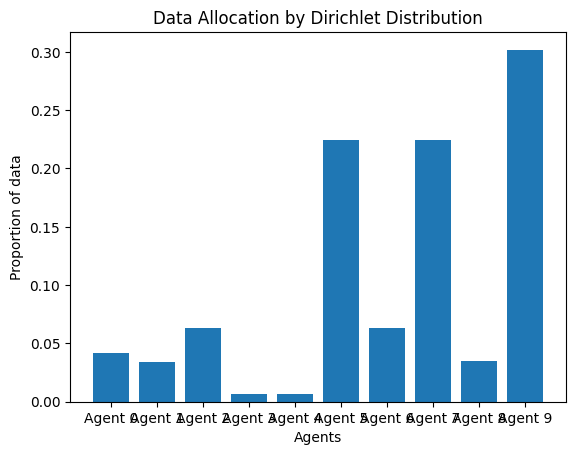

In [ ]:
# Plot the proportions
agents = [f'Agent {i}' for i in range(num_agents)]
plt.bar(agents, train_proportions)
plt.xlabel('Agents')
plt.ylabel('Proportion of data')
plt.title('Data Allocation by Dirichlet Distribution')
plt.show()

# Create Graph Topology

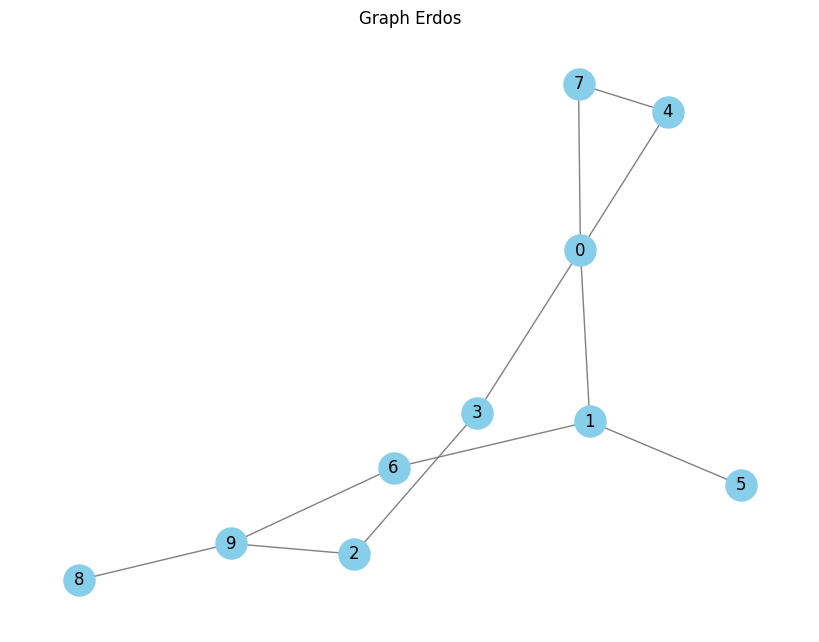

In [ ]:
def genera_grafo_connesso(tipo_grafo, num_nodi, prob=None, m=None):
    while True:
        if tipo_grafo == 'erdos':
            if prob is None:
                raise ValueError("Per un grafo di Erdos-Renyi, specificare la probabilità 'prob'")
            G = nx.erdos_renyi_graph(num_nodi, prob)
        elif tipo_grafo == 'scale_free':
            if m is None:
                raise ValueError("Per un grafo scale-free, specificare il numero di archi 'm'")
            G = nx.barabasi_albert_graph(num_nodi, m)
        else:
            raise ValueError("Tipo di grafo non supportato. Scegliere tra 'erdos_renyi' o 'scale_free'")

        # Controlla se il grafo è connesso
        if nx.is_connected(G):
            break

    adj_matrix = nx.adjacency_matrix(G).todense()
    laplacian_matrix = nx.laplacian_matrix(G).todense()

    plt.figure(figsize=(8, 6))
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray')
    plt.title(f"Graph {tipo_grafo.replace('_', ' ').title()}")
    plt.show()
    return adj_matrix, laplacian_matrix, G

type_g = 'erdos'
p = 0.19
Adj_matrix, L, G = genera_grafo_connesso(type_g, num_agents, prob=p)
# print("Matrice di adiacenza:\n", A)
# print("Laplaciano:\n", L

# Define learning function at the edge of the network

In [ ]:

class Net(nn.Module):
    def __init__(self, input_channels=1, num_classes=10):
        super(Net, self).__init__()

        # Set the seed for reproducibility
        torch.manual_seed(0)

        self.conv1 = nn.Conv2d(input_channels, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 4 * 4)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.xavier_normal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)


# Define Local training of each client and aggregation mechanism:
Local Optimization: $\Psi^t_i = \omega^t_i - \epsilon \nabla_x f_i(\omega^t_i)$


Local Combination: $\omega^{t+1}_i= \sum_{i=1}^N \sum_{j \in N_i} a_{ij}[g(\Psi_i, \Psi_j)]\Psi_j$

given the attraction repulsion function $g()$ s.t. :      
$$ g(y) = a-b[exp^\frac{-||y||^2}{\sigma}]$$
\
The $A_{ij}$ diffusion matrix is defined as:
$A = I - \epsilon L $ and respect stochasticity conditions;

In [ ]:
# Define the diffusion matrix
def get_diffusion(Laplacian):
    eigv, _ = torch.linalg.eig(torch.tensor(Laplacian,  dtype=torch.float32))
    eps = np.random.uniform(0, (2/torch.max(eigv.real).item()))
    #eps = (2/torch.max(eigv.real).item())/2
    #print(f"Learning rate is equal to {round(eps,8)}")
    W = torch.eye(num_agents) - eps * Laplacian
    return W, eps

def flatten_param(model):  # Highlight that you need to pass the
                            # client class and their model (agents.models) as input!
    flattened_params = []
    for name, param in model.named_parameters():
        flattened_params.append(param.data.view(-1))  # Flatten the parameter and add to list
    flattened_vector = torch.cat(flattened_params)  # Concatenate all flattened parameters into a single vector 1D
    return flattened_vector

#Define attraction repulsion function
def g(x, z, pie):
    y = (flatten_param(x))-(flatten_param(z))
    return pie[0]-pie[1]*(-torch.norm(y, p=2)/pie[2])

# Agents class for federated learning
class Agents:
    def __init__(self, train_loaders, val_loaders, test_loader, num_agents, pie = [], lr=None, epochs=5):
        self.train_loaders = train_loaders
        self.val_loaders = val_loaders
        self.test_loader = test_loader
        self.num_agents = num_agents
        self.W, self.lr = get_diffusion(L)
        self.epochs = epochs
        self.models = [Net() for _ in range(num_agents)]
        self.optimizers = [optim.SGD(model.parameters(), lr=self.lr) for model in self.models]
        self.criterion = nn.CrossEntropyLoss()
        self.validation_accuracies = {i: 0 for i in range(num_agents)}  # Dictionary to store validation accuracies
        self.losses = {i: [] for i in range(num_agents)}  # Dictionary to store losses
        #self.W = get_diffusion(L)[0]
        self.pie = pie #attraction repulsion function parameteres

    # def upd_diffusion(self):
    #     Upd_W = torch.tensor(list(self.validation_accuracies.values())) * self.W
    #     row_sums = Upd_W.sum(dim=1, keepdim=True)
    #     m = Upd_W / row_sums #normalize to ensure double stochasticity conditions
    #     return m

    def upd_diffusion(self):
        Upd_w = torch.tensor(list(self.validation_accuracies.values()))*self.W
        M = np.array(Upd_w, dtype=float)
        row_sums = M.sum(axis=1)
        row_sums[row_sums == 0] = 1 #avoid division by zero by setting row sums that are zero to one (this is a really bas case)
        normalized_matrix = M / row_sums[:, np.newaxis]

        #check stochasticity condition
        ones_vector = np.ones(M.shape[0])
        result = np.dot(normalized_matrix, ones_vector)
        if np.allclose(result, ones_vector)== False:
          print("Diffusion matrix do not respect stochasticity conditions")
        return normalized_matrix

    def train_agent(self, agent_idx):
        model = self.models[agent_idx]
        optimizer = self.optimizers[agent_idx]
        train_loader = self.train_loaders[agent_idx]
        val_loader = self.val_loaders[agent_idx]
        model.train()

        for epoch in range(self.epochs):
            running_loss = 0.0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            avg_loss = running_loss / len(train_loader)
            self.losses[agent_idx].append(avg_loss)
            self.validate_agent(agent_idx)
        #print(f'Agent {agent_idx}, Epoch {epoch + 1}, Loss: {round(avg_loss, 2)}')

    def validate_agent(self, agent_idx):
        model = self.models[agent_idx]
        val_loader = self.val_loaders[agent_idx]
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            #print(f'Agent {agent_idx} Validation Accuracy: { (correct / total)}')
        self.validation_accuracies[agent_idx] = correct / total


    def test_agent(self, agent_idx):
        model = self.models[agent_idx]
        test_loader = self.test_loader
        model.eval()

        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = correct / total
        print(f'Agent {agent_idx}  Test Accuracy: {round(test_accuracy * 100, 2)}% ')

        return test_accuracy

    def train_all_agents(self, mechanism=None, visualize_plot=None):
        for agent_idx in range(self.num_agents):
            self.train_agent(agent_idx)
            #update trained weights to the edge of the network
            # trained_state_dict = self.models[agent_idx].state_dict()
            # self.models[agent_idx].load_state_dict(trained_state_dict)
        self.local_combination(mechanism = mechanism)
        self.W = self.upd_diffusion()  # Update diffusion matrix based on validation performances with W1^T=1
        #print(self.W)
        if visualize_plot == True:
          self.plot_losses()

    def FedAvg(self):
        # Initialize zeros parameters to store weighted ones
        for i in range(self.num_agents):
          upd_state_dict = {}
          for n, p in self.models[0].state_dict().items():
              upd_state_dict[n] = torch.zeros_like(p)
          # Perform the aggregation process
          for j in range(self.num_agents):
              for n, p in self.models[j].state_dict().items():
                  upd_state_dict[n] += p
          for n in upd_state_dict:
                  upd_state_dict[n] /= self.num_agents #perform average of parameters
              # Load the updated weights into the i^th agent's model
          #self.models[i].load_state_dict(upd_state_dict)
        for j in range(self.num_agents):
          self.models[j].load_state_dict(upd_state_dict)

        print("Federated avg process has finished;")

#-------------------------------------------------------------------------------
    def aggr_process(self, mechanism = None, k = 1):
        for i in range(self.num_agents):
            upd_state_dict = {}
            # Initialize zeros parameters to store weighted ones
            for n, p in self.models[i].state_dict().items():
                upd_state_dict[n] = torch.zeros_like(p)

            # Perform the aggregation process
            for j in range(self.num_agents):
                for n, p in self.models[j].state_dict().items():
                    # Convert agents.W[i, j] to the same type as p
                    w = self.W[i, j].type(p.dtype)
                    # if mechanism == "Consensus":
                    #   # Accumulate the weighted parameters from other agents
                    #   upd_state_dict[n] += torch.mul(w , p)
                    if mechanism == "BioFL":
                      bio_g = g(self.models[i],self.models[j],self.pie).type(p.dtype)
                      # print(f"agent {i,j} coeff = {bio_g}")
                      upd_state_dict[n] += (w * bio_g )*p
                #print(f"agent {i,j} coeff = {bio_g}")


            # Load the updated weights into the i^th agent's model
            self.models[i].load_state_dict(upd_state_dict)


    def local_combination(self,mechanism=None, max_iterations=150, tolerance=1e-2):
        converged = False
        iteration = 1
        print("Starting the aggregation process...")
        while not converged and iteration < max_iterations:
              if mechanism == "Consensus":
                self.aggr_process(mechanism=mechanism, k = iteration)
              elif mechanism == "BioFL":
                self.aggr_process(mechanism=mechanism)
              elif mechanism =="FedAvg":
                self.FedAvg()
              else:
                print("Check type of aggregation process")
        #    Check for convergence
              converged = True
              i_agent = flatten_param(self.models[0])
              for j_agent in range(0,len(self.models)):
                sum_diff = torch.sum(i_agent - flatten_param(self.models[j_agent]))
                if torch.abs(sum_diff) >= tolerance:
                    converged = False
                    break  # Exit the loop as soon as a pair does not meet the condition
              iteration += 1
        if converged==True:
          print(f"Convergence reached in {iteration} iterations.")
        else:
          print(f"Max iterations ({max_iterations}) reached without convergence.")


    def plot_losses(self):
        for agent_idx in range(self.num_agents):
            plt.plot(self.losses[agent_idx], label=f'Agent {agent_idx}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Federated System Loss behaviour')
        plt.legend()
        plt.show()


In [ ]:
pie_1_values = [1.0]
pie_2_values = np.linspace(0.0, 0.5, 10).tolist()
pie_3_values = [10]

# Use itertools.product to generate all combinations of these values
pie_grid = list(itertools.product(pie_1_values, pie_2_values, pie_3_values))
best_acc = 0.0
best_pie=None

for k in pie_grid:
  print(f"Evaluating params {k}")
  system = Agents(train_loaders, val_loaders, test_loader, num_agents,pie =k ,epochs=5)
  system.train_all_agents("BioFL")
  print("Test accuracy after aggregation process")
  test_acc = system.test_agent(0)
  if test_acc>best_acc:
    best_acc = test_acc
    best_pie = k
print(f"Best pie is {best_pie} with accuracy {best_acc}")

Evaluating params (1.0, 0.0, 10)
Starting the aggregation process...
Convergence reached in 68 iterations.
Test accuracy after aggregation process
Agent 0  Test Accuracy: 11.36% 
Evaluating params (1.0, 0.05555555555555555, 10)
Starting the aggregation process...
Max iterations (150) reached without convergence.
Test accuracy after aggregation process
Agent 0  Test Accuracy: 11.08% 
Evaluating params (1.0, 0.1111111111111111, 10)
Starting the aggregation process...
Convergence reached in 107 iterations.
Test accuracy after aggregation process
Agent 0  Test Accuracy: 83.61% 
Evaluating params (1.0, 0.16666666666666666, 10)
Starting the aggregation process...
Max iterations (150) reached without convergence.
Test accuracy after aggregation process
Agent 0  Test Accuracy: 95.34% 
Evaluating params (1.0, 0.2222222222222222, 10)
Starting the aggregation process...
Convergence reached in 2 iterations.
Test accuracy after aggregation process
Agent 0  Test Accuracy: 9.8% 
Evaluating params (1.

Starting the aggregation process...
Max iterations (150) reached without convergence.


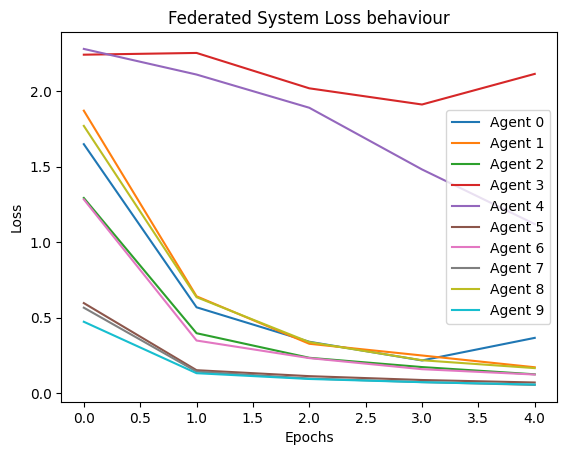

Agent 0  Test Accuracy: 95.02% 
Best attraction-repulsion parameters choosed by grid search are: (1.0, 0.16666666666666666, 10)
Difference after aggregation -0.07560916990041733


In [ ]:
#best_pie = [1.0, 0.35, 10]
system = Agents(train_loaders, val_loaders, test_loader, num_agents,pie =best_pie ,epochs=5)
system.train_all_agents("BioFL", visualize_plot = True)
system.test_agent(0)
print(f"Best attraction-repulsion parameters choosed by grid search are: {best_pie}")
print(f"Difference after aggregation {torch.sum(flatten_param(system.models[0]) - flatten_param(system.models[1]))}")

Starting the aggregation process...
Federated avg process has finished;
Convergence reached in 2 iterations.


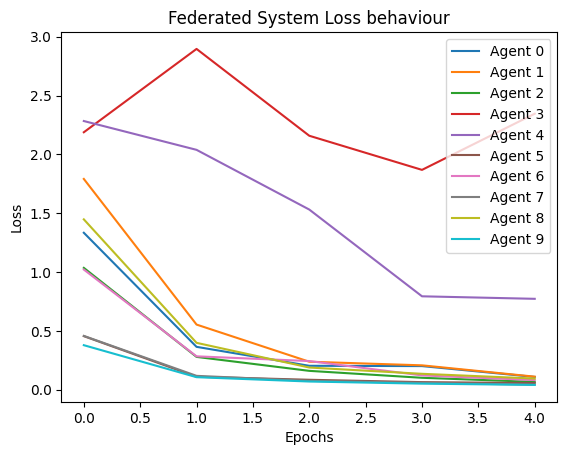

Agent 0  Test Accuracy: 93.27% 
Difference after aggregation 0.0


In [ ]:
system = Agents(train_loaders, val_loaders, test_loader, num_agents,pie =best_pie ,epochs=5)
system.train_all_agents("FedAvg", visualize_plot = True)
system.test_agent(0)
print(f"Difference after aggregation {torch.sum(flatten_param(system.models[0]) - flatten_param(system.models[1]))}")